In [2]:
import numpy as np
import pandas as pd
import os, re, random, gc
import pydicom as pdc
from utils.datahandling_utils import createImageArray


c:\Users\svenalrik\anaconda3\envs\dev-env2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED = 41
BATCH_SIZE = 64
random.seed(SEED)

In [4]:
label_path = "D:/AIFs/AIFs/durable/BorrSci_MR_Data/Output"
image_path = "D:/iCAT_IMAGES"

In [4]:
data = pd.read_csv("data_indices.csv", ",", index_col = 0)
data = data.sort_values(["Patient", "Volume", "Slice"], ignore_index=True)

C:\Users\svenalrik\AppData\Local\Temp\ipykernel_14584\4254050036.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data = pd.read_csv("data_indices.csv", ",", index_col = 0)


In [5]:
# Import images (paths)
from utils.datahandling_utils import createImageIndexCSV
image_data = createImageIndexCSV(image_path)
# Import annotations
mca_labels = pd.read_excel('MCA_labels.xlsx')
mca_labels = mca_labels.drop(mca_labels[mca_labels['Patient'] == 1].index)  # Patient 102(1) contains anomalies
mca_labels = mca_labels.drop(mca_labels[mca_labels['Patient'] == 11].index)  # Patient 112(11) lacks a single pixel array
data = image_data[image_data['Patient'].isin(mca_labels['Patient'])]

In [11]:
def get_patients_from_txt(paths = {"train" : "train_patients.txt", "val" : "val_patients.txt", "test" : "test_patients.txt"}):
    patients = {}
    for name in paths.keys():
        array = np.loadtxt(paths.get(name), dtype=int, delimiter=",", unpack=False)
        patients[name] = array
    return patients

get_patients_from_txt()

{'train': array([63, 21, 19, 33,  2, 61, 45, 30, 46, 35, 65, 43, 52, 12, 28, 70, 40,
        58, 13, 10, 18, 66, 57, 42, 54, 17,  4, 55, 60, 32,  9, 36, 56,  7,
        41, 39, 68,  3,  6, 64, 34, 16, 22, 50, 49, 37, 20, 62, 14, 27, 31,
        44, 25, 23]),
 'val': array([24,  8,  5, 26, 47, 38, 51]),
 'test': array([15, 29, 48, 53, 59, 67, 69])}

In [14]:
def sort_imagedata_on_patients(data: pd.DataFrame, patient_distribution: dict):
    train_patients = patient_distribution.get("train")
    val_patients = patient_distribution.get("val")
    test_patients = patient_distribution.get("test")

    train_mask = np.isin(data["Patient"], train_patients)
    val_mask = np.isin(data["Patient"], val_patients)
    test_mask = np.isin(data["Patient"], test_patients)

    return data[train_mask], data[val_mask], data[test_mask]
dist = get_patients_from_txt()
train_data, val_data, test_data = sort_imagedata_on_patients(data, dist)
        

In [ ]:
from utils.datahandling_utils import filter_on_intensity_and_add_data

def load_and_prepare_images(image_data:pd.DataFrame, labels:pd.DataFrame, vol_intensities:np.ndarray, SEED:int, extra_vols:int = 0, permute:bool = False):
    copy_data = filter_on_intensity_and_add_data(image_data, labels, vol_intensities, extra_vols)
    dist = get_patients_from_txt()
    train_images, val_images, test_images = sort_imagedata_on_patients(copy_data, dist)

    train_labels = np.isin(labels['Patient'], np.unique(train_images['Patient']))
    train_labels = labels[train_labels]
    val_labels = np.isin(labels['Patient'], np.unique(val_images['Patient']))
    val_labels = labels[val_labels]
    test_labels = np.isin(labels['Patient'], np.unique(test_images['Patient']))
    test_labels = labels[test_labels]

    if permute:
        train_labels['Label'] = train_labels['Label'].sample(frac=1, random_state=SEED).values
    
    label_train_true_size, label_train_size = len(train_labels[train_labels['Label'] == 1]) + len(train_images) - len(train_labels), len(train_images)
    label_test_true_size, label_test_size = len(test_labels[test_labels['Label'] == 1]) + len(test_images) - len(test_labels), len(test_images)
    print(f"Size training, val, and test data: {len(train_images)}, {len(val_images)}, {len(test_images)}.")
    print(f"True labels in training: {label_train_true_size} of {label_train_size} ({round(label_train_true_size/label_train_size, 3)*100}%).")
    print(f"True labels in test: {label_test_true_size} of {label_test_size} ({round(label_test_true_size/label_test_size, 3)*100}%)")

    return train_images, val_images, test_images, train_labels, val_labels, test_labels

In [6]:
def crop_image(image: np.ndarray, reduction: float = 0.70):
    y_bottom, y_top = int(image.shape[0]*reduction), int(image.shape[0]*(1-reduction))
    return image[y_top:y_bottom, y_top:y_bottom]

In [7]:
patient = data.loc[(data['Patient']== 36) & (data['Slice']==18) & (data['Volume']==20)]
dcm = pdc.read_file(patient['ImagePath'].item()).pixel_array

reduction: float = 0.70
y_bottom, y_top = int(dcm.shape[0]*reduction), int(dcm.shape[0]*(1-reduction))
dcm_crop = dcm[y_top:y_bottom, y_top:y_bottom]
print(f"Image dimensions reduced from {dcm.shape} to {dcm_crop.shape}")

Image dimensions reduced from (160, 160) to (64, 64)


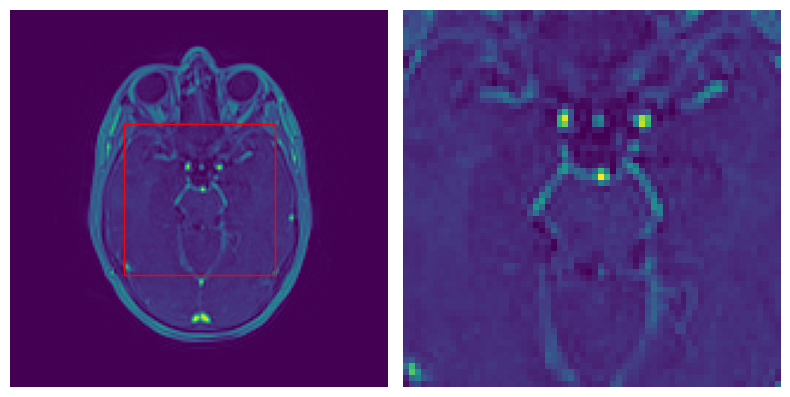

In [8]:
import matplotlib.pyplot as plt
import matplotlib.lines as line
fig, axs = plt.subplots(1,2, figsize=(8,10))
axs[0].imshow(dcm)
axs[0].add_artist(line.Line2D([y_bottom, y_bottom], [y_top, y_bottom], color='red', linewidth=1)) # Høyre
axs[0].add_artist(line.Line2D([y_top, y_top], [y_top, y_bottom], color='red', linewidth=1))       # Venstre
axs[0].add_artist(line.Line2D([y_bottom, y_top], [y_top, y_top], color='red', linewidth=1))       # Topp
axs[0].add_artist(line.Line2D([y_bottom, y_top], [y_bottom, y_bottom], color='red', linewidth=1)) # Bunn
axs[0].axis('off')
axs[1].imshow(dcm_crop)
axs[1].axis('off')
fig.tight_layout()

In [9]:
data1 = pd.read_csv("new_indices.csv", ",", index_col = 0)
data1 = data1.sort_values(["Patient", "Volume", "Slice"], ignore_index=True)

C:\Users\svenalrik\AppData\Local\Temp\ipykernel_14584\3484073970.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data1 = pd.read_csv("new_indices.csv", ",", index_col = 0)


In [10]:
def createImageArray(paths):
    base_slice = pdc.read_file(paths.iloc[[0]]['ImagePath'].item())
    base_slice = base_slice.pixel_array
    slices = np.zeros((np.max(paths['Volume']), np.max(paths['Slice']), base_slice.shape[0], base_slice.shape[1]))
    for volume_num in range(1, slices.shape[0]+1):
        for slice_num in range(1, slices.shape[1]+1):
            try:
                path = paths.loc[(paths['Volume'] == volume_num) & (paths['Slice'] == slice_num)]
                image = pdc.read_file(path['ImagePath'].item())
                slices[volume_num-1, slice_num-1, :, :] = image.pixel_array
            except: 
                print("Failed \n")
                print(f"Path: {path} \n")
                print(f"Volume: {volume_num} Slice: {slice_num}")
                break
    return slices

In [11]:
image = pdc.read_file("D:/AIF_DCE/112/DCE/Image#2656.dcm")

In [14]:
image.PatientAge

'064Y'